FileNotFoundError: [Errno 2] No such file or directory: 'True.csv'

In [ ]:
import pandas as pd
import numpy as np
import nltk
import pickle
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
true = pd.read_csv('/content/True.csv')
fake = pd.read_csv('/content/Fake.csv')

In [ ]:
true['label'] = 1
fake['label'] = 0

In [ ]:
frames = [true.loc[:5000][:], fake.loc[:5000][:]]
df = pd.concat(frames)

In [ ]:
X = df.drop('label', axis=1)
y = df['label']
corpus = df['text'].values

In [ ]:
# Define a function to clean the text
def clean_text(text):
    # Remove punctuation and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stopwords and stem the words
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text.split() if word not in stopwords.words('english')]

    # Join the words back into a string
    text = ' '.join(text)

    return text

In [ ]:
# Apply the clean_text function to the corpus
corpus = [clean_text(doc) for doc in corpus]

corpus = [doc for doc in corpus if doc]

In [ ]:
# Tokenize the corpus
corpus = [word_tokenize(doc) for doc in corpus]
# Step 1: TF-IDF vectorization
corpus = [' '.join(doc) for doc in corpus]
# Initialize the vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit and transform the corpus
tfidf_matrix = vectorizer.fit_transform(corpus)

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

In [ ]:
# Save the vectorizer using pickle
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
df.head(2)
df2 = df.copy()
df2.reset_index(inplace=True)
df2.shape
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(df2)):
    review = re.sub('[^a-zA-Z]', ' ', df2['text'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
# Saving the corpus
with open('corpus.pkl', 'wb') as file:
    pickle.dump(corpus, file)

In [ ]:
# Topic Modeling
vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1,3))
data_vectorized = vectorizer.fit_transform(corpus)

lda_model = LatentDirichletAllocation(n_components=10)
lda_model.fit_transform(data_vectorized)

array([[0.01466642, 0.77394562, 0.10872343, ..., 0.01466548, 0.01466679,
        0.01466639],
       [0.84607108, 0.01710361, 0.01710173, ..., 0.01710235, 0.0171036 ,
        0.01710399],
       [0.01735305, 0.01735286, 0.01735151, ..., 0.84382319, 0.01735483,
        0.01735391],
       ...,
       [0.01706663, 0.01706808, 0.01706733, ..., 0.01706604, 0.01706865,
        0.0170669 ],
       [0.01845795, 0.01845894, 0.01845811, ..., 0.018459  , 0.01846034,
        0.01845867],
       [0.01669843, 0.01669534, 0.01669362, ..., 0.01669455, 0.84975037,
        0.01669338]])

In [ ]:
# Word Embeddings
model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, sg=0)
word_embeddings = model.wv
def document_vector(doc, model):
    # Creating an empty array for the document vector
    # Assuming Word2Vec vectors have a size of 100
    doc_vec = np.zeros(100)

    # Count the number of words in the document
    num_words = 0

    for word in doc:
        if word in model:
            doc_vec += model[word]
            num_words += 1

    if num_words > 0:
        doc_vec /= num_words

    return doc_vec

In [ ]:
X = [document_vector(doc, word_embeddings) for doc in corpus]
X = np.array(X)
y = df2['label']
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10002, 100)
y shape: (10002,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Model building - Passive Aggresive Classifier
classifier = PassiveAggressiveClassifier(max_iter=1000)
classifier.fit(X_train, y_train)

PassiveAggressiveClassifier()

In [ ]:
# Performance Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, pred) * 100
precision = precision_score(y_test, pred) * 100
recall = recall_score(y_test, pred) * 100
f1 = f1_score(y_test, pred) * 100
roc_auc = roc_auc_score(y_test, pred) * 100

In [ ]:
print("Accuracy: %0.3f" % accuracy)
print("Precision: %0.3f" % precision)
print("Recall: %0.3f" % recall)
print("F1 Score: %0.3f" % f1)
print("ROC AUC Score: %0.3f" % roc_auc)

Accuracy: 83.278
Precision: 78.757
Recall: 91.969
F1 Score: 84.852
ROC AUC Score: 83.114


Confusion Matrix without Normalization


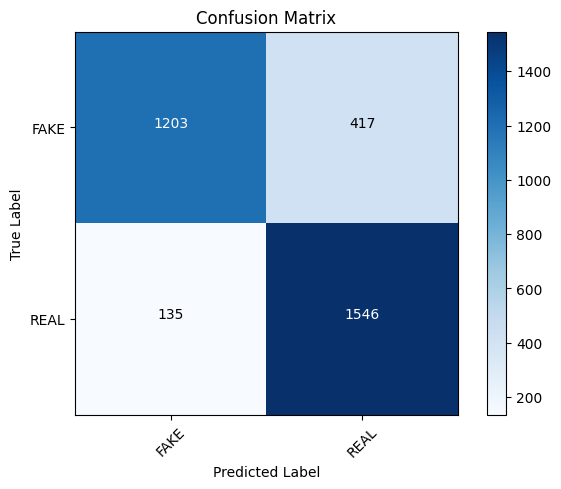

In [ ]:
# Confusion Matrix Plot Function
import matplotlib.pyplot as plt
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix without Normalization')

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [ ]:
from flask import Flask, render_template, request, jsonify

app = Flask(__name__)

model = pickle.load(open('classifier.pkl', 'rb'))
w2v_model = Word2Vec.load('word2vec.model')

@app.route('/', methods=['GET'])
def home():
    return render_template('index.html')

def preprocess_text(text):
    # Function to clean and preprocess the input text
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower()
    review = word_tokenize(review)
    review = [word for word in review if word not in stopwords.words('english')]
    return review

def predict(text):
    review = preprocess_text(text)

    # Use Word2Vec for feature extraction
    review_vect = np.array([w2v_model.wv[word] for word in review if word in w2v_model.wv.key_to_index])

    # Check if the array is empty
    if review_vect.size == 0:
        return 'REAL'

    review_vect = np.mean(review_vect, axis=0)

    # Update the number of features used for prediction
    if review_vect.shape[0] != 100:
        review_vect = review_vect[:100]  # Keep only the first 100 features if there are more

    # Reshape the vector to match the shape used during training
    review_vect = review_vect.reshape(1, -1)

    prediction = 'FAKE' if model.predict(review_vect) == 0 else 'REAL'
    return prediction


@app.route('/', methods=['POST'])
def webapp():
    text = request.form['text']
    prediction = predict(text)
    return render_template('index.html', text=text, result=prediction)

@app.route('/predict/', methods=['GET','POST'])
def api():
    text = request.args.get("text")
    prediction = predict(text)
    return jsonify(prediction=prediction)

if __name__ == "__main__":
    app.run()